In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ultralytics opencv-python-headless torch torchvision transformers pillow opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.6/871.6 kB 21.0 MB/s eta 0:00:00


In [55]:
from ultralytics import YOLO
import os
import cv2
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import pandas as pd
import json
import glob
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from google.colab.patches import cv2_imshow
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import ViTForImageClassification, ViTImageProcessor, AutoModelForImageClassification, AutoFeatureExtractor
import torch

In [27]:
# 테스트 코드
yolo_model_path = '/content/drive/MyDrive/project/KDT_kiosk/model/pre_yolov8face/yolov8n-face.pt'
# YOLOv8 모델 로드
yolo_model = YOLO(yolo_model_path)

# 예측할 이미지 경로 설정
image_path = '/content/drive/MyDrive/project/KDT_kiosk/model/pre_yolov8face/minji.jpg'  # 샘플 이미지 경로 설정

# cap과 동일한 형식으로 test
frame = cv2.imread(image_path)

# 예측 수행
results = yolo_model(frame)

# 결과 저장 경로 설정
save_dir = '/content/drive/MyDrive/project/KDT_kiosk/model/pre_yolov8face/result'

# 리스트의 각 결과를 순회하면서 이미지 저장
for i, result in enumerate(results):
    # 이미지 저장 경로 설정
    save_path = os.path.join(save_dir, f"result_{i}.jpg")

    # 결과 이미지 저장
    result.save(save_path)


0: 640x480 1 face, 210.1ms
Speed: 6.0ms preprocess, 210.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 480)


In [64]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: ultralytics.engine.results.Keypoints object
 masks: None
 names: {0: 'face'}
 obb: None
 orig_img: array([[[254, 237, 218],
         [254, 237, 218],
         [254, 237, 218],
         ...,
         [253, 224, 155],
         [253, 224, 155],
         [253, 224, 155]],
 
        [[254, 237, 218],
         [254, 237, 218],
         [254, 237, 218],
         ...,
         [254, 225, 156],
         [254, 225, 156],
         [254, 225, 156]],
 
        [[254, 237, 218],
         [254, 237, 218],
         [254, 237, 218],
         ...,
         [254, 225, 156],
         [254, 225, 156],
         [254, 225, 156]],
 
        ...,
 
        [[228, 200, 176],
         [228, 200, 176],
         [228, 200, 176],
         ...,
         [249, 218, 187],
         [250, 219, 188],
         [251, 220, 189]],
 
        [[228, 200, 176],
         [228, 200, 176],
         [228, 200, 1

In [28]:
boxes = results[0].boxes
boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.8671])
data: tensor([[212.0000,  99.0000, 359.0000, 307.0000,   0.8671,   0.0000]])
id: None
is_track: False
orig_shape: (772, 550)
shape: torch.Size([1, 6])
xywh: tensor([[285.5000, 203.0000, 147.0000, 208.0000]])
xywhn: tensor([[0.5191, 0.2630, 0.2673, 0.2694]])
xyxy: tensor([[212.,  99., 359., 307.]])
xyxyn: tensor([[0.3855, 0.1282, 0.6527, 0.3977]])

In [29]:
boxes.xyxy

tensor([[212.,  99., 359., 307.]])

In [47]:
box = results[0].boxes.xyxy[0]
box[0]

tensor(212.)

In [59]:
# 사전학습모델 경로 설정
yolo_model_path = '/content/drive/MyDrive/project/KDT_kiosk/model/pre_yolov8face/yolov8n-face.pt'
gender_model_name = 'rizvandwiki/gender-classification'
gender_model = AutoModelForImageClassification.from_pretrained(model_name)
gender_feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

# 사전학습모델 모델 로드
yolo_model = YOLO(yolo_model_path)


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
model_name = 'rizvandwiki/gender-classification'
config = AutoConfig.from_pretrained(model_name)

# 라벨 정보 확인
print(config)


0: 640x480 1 face, 480.9ms
Speed: 14.5ms preprocess, 480.9ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 480)


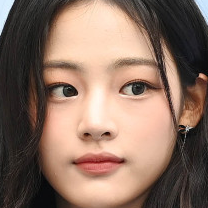

In [69]:
# 얼굴 크롭 잘되는지 테스트 코드

def face_crop(frame, save_dir='/content/drive/MyDrive/project/KDT_kiosk/model/pre_gender_huggingface'):
    # YOLOv8 모델을 사용하여 얼굴 감지 (BGR 형식으로 직접 처리)
    results = yolo_model(frame)

    # 결과에서 얼굴 이미지 추출 및 저장
    box = results[0].boxes.xyxy[0]

    # 감지된 얼굴의 바운딩 박스 좌표
    x1, y1, x2, y2 = int(box[0].item()), int(box[1].item()), int(box[2].item()), int(box[3].item())

    # 좌표 보정 (이미지 범위를 벗어나지 않도록)
    x1 = max(x1, 0)
    y1 = max(y1, 0)
    x2 = min(x2, frame.shape[1])
    y2 = min(y2, frame.shape[0])

    # 바운딩 박스의 중심 좌표와 크기 계산
    center_x = (x1 + x2) // 2
    center_y = (y1 + y2) // 2
    width = x2 - x1
    height = y2 - y1
    size = max(width, height)  # 긴쪽을 기준으로 크기 결정

    # 정사각형 영역으로 얼굴 크롭
    x1_new = max(center_x - size // 2, 0)
    y1_new = max(center_y - size // 2, 0)
    x2_new = min(center_x + size // 2, frame.shape[1])
    y2_new = min(center_y + size // 2, frame.shape[0])

    # 얼굴 이미지 추출
    face_img = frame[y1_new:y2_new, x1_new:x2_new]
    face_pil = Image.fromarray(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))  # BGR에서 RGB로 변환

    return face_pil

image_path = '/content/drive/MyDrive/project/KDT_kiosk/model/pre_yolov8face/minji.jpg'
frame = cv2.imread(image_path)
cropped_face = face_crop(frame)
cropped_face

In [70]:
# 분류 모델이 잘 돌아가는지 테스트 코드 - 일단은 성별

def classify_gender(face_pil):
    # 이미지를 모델이 요구하는 형식으로 전처리
    inputs = gender_feature_extractor(images=face_pil, return_tensors="pt")

    # 모델을 사용하여 성별 예측
    with torch.no_grad():
        outputs = gender_model(**inputs)

    # 예측 결과에서 라벨 추출
    logits = outputs.logits
    predicted_class_id = logits.argmax(-1).item()
    predicted_label = gender_model.config.id2label[predicted_class_id]

    return predicted_label

classify_gender(cropped_face)

'female'

In [71]:
# 얼굴 탐지 ~ 분류모델까지 코드

def process_frame(frame, save_dir='/content/drive/MyDrive/project/KDT_kiosk/model/pre_gender_huggingface'):
  '''
  캠에서 캡처한 프레임을 받아서 분류별 라벨을 반환
  얼굴탐지 - Yolov8-face 모델
  성별분류 - Huggingface 모델
  인종분류 - 추가예정
  나이분류 - 추가예정
  감정분류 - 추가예정
  '''
    # YOLOv8 모델을 사용하여 얼굴 감지 (BGR 형식으로 직접 처리)
    results = yolo_model(frame)

    # 결과에서 얼굴 이미지 추출 및 저장
    box = results[0].boxes.xyxy[0]

    # 감지된 얼굴의 바운딩 박스 좌표
    x1, y1, x2, y2 = int(box[0].item()), int(box[1].item()), int(box[2].item()), int(box[3].item())

    # 좌표 보정 (이미지 범위를 벗어나지 않도록)
    x1 = max(x1, 0)
    y1 = max(y1, 0)
    x2 = min(x2, frame.shape[1])
    y2 = min(y2, frame.shape[0])

    # 바운딩 박스의 중심 좌표와 크기 계산
    center_x = (x1 + x2) // 2
    center_y = (y1 + y2) // 2
    width = x2 - x1
    height = y2 - y1
    size = max(width, height)  # 긴쪽을 기준으로 크기 결정

    # 정사각형 영역으로 얼굴 크롭
    x1_new = max(center_x - size // 2, 0)
    y1_new = max(center_y - size // 2, 0)
    x2_new = min(center_x + size // 2, frame.shape[1])
    y2_new = min(center_y + size // 2, frame.shape[0])

    # 얼굴 이미지 추출
    face_img = frame[y1_new:y2_new, x1_new:x2_new]
    face_pil = Image.fromarray(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))  # BGR에서 RGB로 변환

    # 이미지를 모델이 요구하는 형식으로 전처리
    inputs = gender_feature_extractor(images=face_pil, return_tensors="pt")

    # 모델을 사용하여 성별 예측
    with torch.no_grad():
        outputs = gender_model(**inputs)

    # 예측 결과에서 라벨 추출
    logits = outputs.logits
    predicted_class_id = logits.argmax(-1).item()
    predicted_label = gender_model.config.id2label[predicted_class_id]

    return predicted_label

In [72]:
image_path = '/content/drive/MyDrive/project/KDT_kiosk/model/pre_yolov8face/minji.jpg'
frame = cv2.imread(image_path) # cv2.VideoCapture(0)에서 이미지를 반환하는 형식과 동일함
process_frame(frame)


0: 640x480 1 face, 642.9ms
Speed: 9.0ms preprocess, 642.9ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 480)


'female'

In [ ]:
# 실시간 카메라 캡처 및 얼굴 인식
def capture_and_predict():
    # 카메라 초기화 (0은 기본 카메라를 의미)
    cap = cv2.VideoCapture(0)

    while True:
        # 프레임 캡처
        ret, frame = cap.read()
        if not ret:
            break

        # 얼굴 인식 및 분류
        sex_label, race_label, age_label, emotion_label = process_frame(frame)

        # 결과가 나온 라벨로 UI변경이 있어야하는데 어떻게할지

        # 'q' 키를 누르면 종료
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # 카메라 해제 및 창 닫기
    cap.release()
    cv2.destroyAllWindows()

# 카메라 캡처 및 예측 시작
capture_and_predict()